<a href="https://colab.research.google.com/github/LogeswaranSR/Dogs-vs-Cats/blob/main/CNN_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Our motive is to develop a CNN model that perfectly classifies Cats and Dogs images.

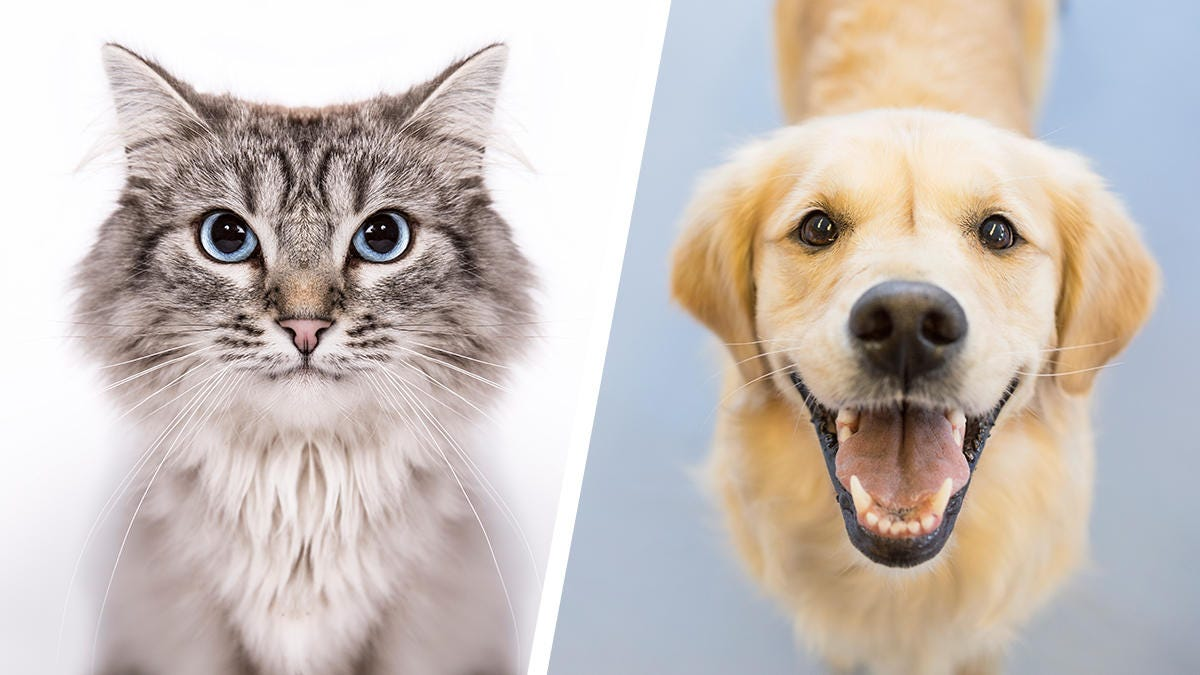

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import time

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

## Dataset

The Dataset is from 'Dogs-vs-Cats' Competition in Kaggle (Ended 10 yrs ago - as of 17/11/23)

The Dataset consists of 25,000 pictures of Dogs and Cats in its Training Data

The Test data contains 12,500 unlabelled pictures of Dogs and Cats.

The motive of the competition is to develop a model that correctly predicts the Dogs and Cats, based on the given dataset.

Ensure to join the competition before downloading dataset

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
! unzip dogs-vs-cats.zip
!mkdir ./dogs-vs-cats
!unzip train.zip -d ./dogs-vs-cats
!mkdir ./dogs-vs-cats/test
!unzip test1.zip -d ./dogs-vs-cats/test

Streaming output truncated to the last 5000 lines.
  inflating: ./dogs-vs-cats/test/test1/5499.jpg  
  inflating: ./dogs-vs-cats/test/test1/55.jpg  
  inflating: ./dogs-vs-cats/test/test1/550.jpg  
  inflating: ./dogs-vs-cats/test/test1/5500.jpg  
  inflating: ./dogs-vs-cats/test/test1/5501.jpg  
  inflating: ./dogs-vs-cats/test/test1/5502.jpg  
  inflating: ./dogs-vs-cats/test/test1/5503.jpg  
  inflating: ./dogs-vs-cats/test/test1/5504.jpg  
  inflating: ./dogs-vs-cats/test/test1/5505.jpg  
  inflating: ./dogs-vs-cats/test/test1/5506.jpg  
  inflating: ./dogs-vs-cats/test/test1/5507.jpg  
  inflating: ./dogs-vs-cats/test/test1/5508.jpg  
  inflating: ./dogs-vs-cats/test/test1/5509.jpg  
  inflating: ./dogs-vs-cats/test/test1/551.jpg  
  inflating: ./dogs-vs-cats/test/test1/5510.jpg  
  inflating: ./dogs-vs-cats/test/test1/5511.jpg  
  inflating: ./dogs-vs-cats/test/test1/5512.jpg  
  inflating: ./dogs-vs-cats/test/test1/5513.jpg  
  inflating: ./dogs-vs-cats/test/test1/5514.jpg  
  i

Defining the image standards for the model

In [ ]:
im_size = (128, 128)
im_width, im_height = im_size
im_channels = 3

Now, We create a Pandas Dataframe containing

*   File names of the Images in Training Data
*   Category of the Image (Dog or Cat)


In [ ]:
filenames = os.listdir("./dogs-vs-cats/train")
categories=[]

for f in filenames:
    cat = f.split('.')[0]
    if cat=='dog':
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filenames':filenames,
    'category':categories
})

## Model Structure

The model is a Convolutional Neural Network containing the following structure.

In [ ]:
def create_model(no_of_conv_layers, no_of_kernels=32):
  final_layers = [
      Flatten(),
      Dense(512, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(2, activation='softmax')
  ]
  conv_layers = [ Input(shape=(im_width, im_height, im_channels)) ]
  for i in range(no_of_conv_layers):
    conv_layers.append(Conv2D(no_of_kernels * (2**i), (3,3), activation='relu'))
    conv_layers.extend([
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25)
    ])
  layers = conv_layers + final_layers
  model = Sequential(layers)

  model.compile(loss = 'categorical_crossentropy',
                optimizer = 'rmsprop',
                metrics=['accuracy'])
  earlystop = EarlyStopping(patience = 10)
  learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
  callbacks = [earlystop, learning_rate_reduction]
  return model, callbacks

# model.summary()

## ImageDataGenerator

[ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is a Preprocessing tool for images, provided by the Keras Library. Its main motive is to generate batches of tensor image data with real-time data augmentation.

Data Augmentation is the concept of producing new images to our dataset by introducing variations to our images (such as rotation, scaling, zooming, etc.)

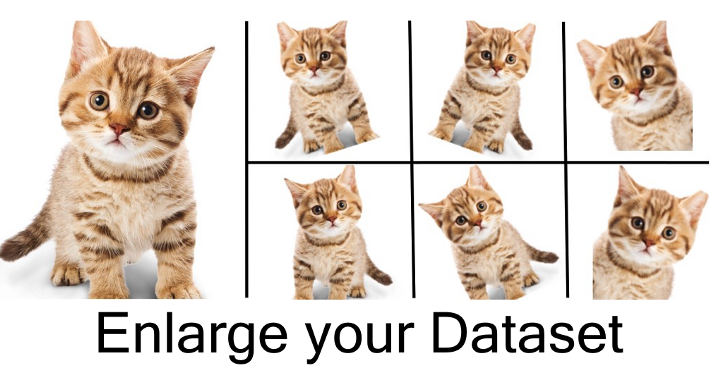

Data Augmentation is very useful for CNN as it helps the model to adapt to the changes in the image, and produce the correct output irrespective of the differences.

To implement Data Augmentation in real-time, we introduce ImageDataGenerator class to our Training.

First we need to split our Training dataset to Training and Validation Dataset. We split the dataset in the ratio of 80:20 for this purpose.

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_val = val_df.shape[0]
batch_size=15
print("Total images in Training Dataset:", total_train)
print("Total images in Validation Dataset:", total_val)

Total images in Training Dataset: 20000
Total images in Validation Dataset: 5000


In [ ]:
## Train Data Generator
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    "./dogs-vs-cats/train/",
                                                    x_col='filenames',
                                                    y_col='category',
                                                    target_size=im_size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
## Validation Data Generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(val_df,
                                                "./dogs-vs-cats/train/",
                                                x_col='filenames',
                                                y_col='category',
                                                target_size=im_size,
                                                class_mode='categorical',
                                                batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


## Model Training

In [ ]:
! mkdir ./models

epochs=10
model_training = {}

In [ ]:
for i in range(5):
  key = str(i+1)+"_Layers"
  begin = time.time()
  model, callbacks = create_model(i+1, 32)
  print("------------------------------ "+key+"-----------------------------")
  history = model.fit(
      train_generator,
      epochs=epochs,
      validation_data=val_generator,
      validation_steps=total_val//batch_size,
      steps_per_epoch=total_train//batch_size,
      callbacks=callbacks
  )
  end=time.time()
  runtime = end-begin
  print("\n\n\n\t\t\tEvaluation:")
  evaluation = model.evaluate(val_generator)
  model_training[key] = [runtime, history, evaluation]
  model.save(r"./models/model_"+key+".h5")
  del model
  print('\n\n')

------------------------------ 1_Layers-----------------------------
Epoch 1/10
1333/1333 [==============================] - 158s 108ms/step - loss: 0.7675 - accuracy: 0.6107 - val_loss: 0.6884 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 141s 106ms/step - loss: 0.6307 - accuracy: 0.6615 - val_loss: 0.5394 - val_accuracy: 0.7247 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 140s 105ms/step - loss: 0.6075 - accuracy: 0.6802 - val_loss: 0.5544 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 140s 105ms/step - loss: 0.5936 - accuracy: 0.6895 - val_loss: 0.5395 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 140s 105ms/step - loss: 0.5828 - accuracy: 0.7000 - val_loss: 0.6919 - val_accuracy: 0.6945 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - ETA: 0s - loss: 0.5768 - accuracy: 0.7028
Epoch 6: ReduceLROnPlateau r

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(





------------------------------ 2_Layers-----------------------------
Epoch 1/10
1333/1333 [==============================] - 141s 104ms/step - loss: 0.7506 - accuracy: 0.6192 - val_loss: 0.7913 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 142s 106ms/step - loss: 0.6048 - accuracy: 0.6832 - val_loss: 0.5644 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 140s 105ms/step - loss: 0.5615 - accuracy: 0.7190 - val_loss: 0.5786 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 140s 105ms/step - loss: 0.5333 - accuracy: 0.7390 - val_loss: 0.5469 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 141s 106ms/step - loss: 0.5186 - accuracy: 0.7506 - val_loss: 0.4709 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - 140s 105ms/step - loss: 0.4936 - accuracy: 0.7686 - val_loss: 0.576

In [ ]:
# model.save(r'model1_catsVSdogs_10epoch.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save(r"model1_catsVSdogs_10epochs", save_format='tf')

## Model Analysis

In [ ]:
plt.figure(figsize=(12,24))


## Inference

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
im_size = (128, 128)
im_width, im_height = im_size
im_channels = 3
classes = {0:'cat', 1:'dog'}

In [ ]:
def inference(model, filepath):
    img = Image.open(filepath)
    img = img.resize(im_size)
    img = np.expand_dims(img, axis=0)
    img = np.array(img) / 255
    pred = model.predict(img)
    pred = pred.argmax(axis=1)
    return pred

In [ ]:
res={}
for index, row in sample_rows.iterrows():
    pred = inference(model, "./dogs-vs-cats/test/test1/"+row['filenames'])
    res[row['filenames']]=classes[pred[0]]
res

1/1 [==============================] - 0s 17ms/step


{'2295.jpg': 'dog',
 '7146.jpg': 'cat',
 '3295.jpg': 'cat',
 '3196.jpg': 'dog',
 '11794.jpg': 'cat',
 '1971.jpg': 'cat',
 '3231.jpg': 'cat',
 '7508.jpg': 'cat',
 '2953.jpg': 'cat',
 '10588.jpg': 'dog',
 '1929.jpg': 'cat',
 '3336.jpg': 'dog',
 '12105.jpg': 'cat',
 '6071.jpg': 'cat',
 '11914.jpg': 'cat',
 '9612.jpg': 'dog',
 '7057.jpg': 'cat',
 '11951.jpg': 'dog',
 '45.jpg': 'cat',
 '3706.jpg': 'dog'}